<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_04_auto_ml_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Tuning

In [0]:
COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v1'

In [2]:
if COLAB:
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects

Cloning into 'dl-projects'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 977 (delta 22), reused 9 (delta 4), pack-reused 936
Receiving objects: 100% (977/977), 69.87 MiB | 12.15 MiB/s, done.
Resolving deltas: 100% (570/570), done.


In [0]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .
  !cp dl-projects/plot* .

In [0]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import matplotlib
import sys

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

import featuretools as ft

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, mean_squared_error, accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

# from sklearn.ensemble import RandomForestClassifier

# from scikitplot.plotters import plot_precision_recall_curve

from dateutil.relativedelta import relativedelta

from IPython.display import display

from utils import *
from preprocess import *

import xgboost as xgb

np.set_printoptions(threshold=sys.maxsize)

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

from utils import feature_selection, plot_feature_importances
from plot import plot_correlation_matrix, plot_labelled_scatter

In [6]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [7]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.pkl"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 4630M
-rw------- 1 root root 1555M Jan  5 23:01 feature_matrix_d2.pkl
-rw------- 1 root root 1528M Jan  7 00:07 feature_matrix_d2_v1_origin.pkl
-rw------- 1 root root 1548M Jan  7 00:07 feature_matrix_d2_v1.pkl
total 1M
-rw-r--r-- 1 root root 1M Jan  8 14:11 4D.zip


In [0]:
data = pd.read_pickle(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959893 entries, 0 to 959892
Columns: 213 entries, NumberId to year
dtypes: datetime64[ns](1), float64(146), int64(64), uint8(2)
memory usage: 1.5 GB


## Exploratory Data Analysis

### View data

In [0]:
feature_matrix = data

In [12]:
print(feature_matrix.columns)

Index(['NumberId', 'time', 'STD(Results.LuckyNo)', 'STD(Results.TotalStrike)',
       'STD(Results.DrawNo)', 'MAX(Results.LuckyNo)',
       'MAX(Results.TotalStrike)', 'MAX(Results.DrawNo)',
       'MIN(Results.LuckyNo)', 'MIN(Results.TotalStrike)',
       ...
       'PERCENTILE(LAST(Results.TotalStrike))',
       'PERCENTILE(LAST(Results.LuckyNo))',
       'PERCENTILE(NUM_UNIQUE(Results.PrizeType))',
       'PERCENTILE(MEAN(Results.DrawNo))', 'TotalStrike', 'Label',
       'MODE(Results.PrizeType)_Prize', 'LAST(Results.PrizeType)_Prize',
       'month', 'year'],
      dtype='object', length=213)


In [13]:
feature_matrix[feature_matrix['Label'] == 1 ].tail(4)

,NumberId,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),...,CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year
950205,9957,2019-12-01,0.0,0.0,127054.467100,9957,1,479318,9957,1,140498,9957,1,311519.333333,0.0,0.0,-0.012912,9957,1,100862,479318,78019200.0,9,89613,9,2803674,0.0,0.0,0.032599,1,16,9,0,669254340.0,63521.940426,2.338165e+08,0.274341,1.452695e+08,29218.946689,0.0,...,1.0,5004.820912,1.0,266657.801609,27,6,0,0.50005,0.50005,0.8357,0.916225,0.4834,0.32300,0.32300,0.9958,0.50005,0.89905,0.50005,0.50005,0.50005,0.485937,0.56675,0.50005,0.9958,0.50005,0.3915,0.9958,0.56380,0.56675,0.50005,0.50005,0.9958,0.50005,0.8226,1.0,1,1,1,12,2019
950206,9964,2019-12-01,0.0,0.0,87070.473740,9964,1,343510,9964,1,100096,9964,1,220612.090909,0.0,0.0,-0.225108,9964,1,69635,343510,46483200.0,11,109604,11,2426733,0.0,0.0,0.031344,1,17,2,0,750643140.0,43536.467551,1.666614e+08,0.188005,9.967259e+07,20027.865006,0.0,...,1.0,4999.691371,1.0,261837.337829,10,11,0,0.50005,0.50005,0.9263,0.035232,0.3364,0.56205,0.56205,0.9965,0.50005,0.74750,0.50005,0.50005,0.50005,0.329597,0.02420,0.50005,0.9965,0.50005,0.0351,0.9965,0.04675,0.02420,0.50005,0.50005,0.9965,0.50005,0.1111,1.0,1,1,1,12,2019
950207,9989,2019-12-01,0.0,0.0,111384.241449,9989,1,434715,9989,1,41692,9989,1,219502.777778,0.0,0.0,0.437460,9989,1,90599,434715,93031200.0,9,89901,9,1975525,0.0,0.0,0.031669,1,27,5,0,868233540.0,55681.529797,2.109426e+08,0.240496,1.274390e+08,25613.543923,0.0,...,1.0,5110.967890,1.0,253949.170276,27,12,0,0.50005,0.50005,0.8375,0.122710,0.1801,0.32300,0.32300,0.9990,0.50005,0.02170,0.50005,0.50005,0.50005,0.792313,0.20020,0.50005,0.9990,0.50005,0.1763,0.9990,0.74565,0.20020,0.50005,0.50005,0.9990,0.50005,0.1059,1.0,1,1,1,12,2019
950208,9990,2019-12-01,0.0,0.0,158865.967466,9990,1,498619,9990,1,74194,9990,1,24

In [14]:
origin_data[origin_data.LuckyNo == 3294]

,DrawNo,DrawDate,PrizeType,LuckyNo
14682,104596,1996-06-01,ConsolationNo5,3294
74388,364212,2012-01-15,ConsolationNo3,3294
74684,365512,2012-02-08,ConsolationNo1,3294
81028,393013,2013-08-25,SpecialNo9,3294
82313,398613,2013-12-18,SpecialNo6,3294
91527,438716,2016-03-13,ConsolationNo7,3294
98921,470818,2018-01-03,SpecialNo8,3294
103177,489319,2019-01-19,SpecialNo9,3294


In [15]:
feature_matrix.describe().round(2)

,NumberId,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),STD(Results.PERCENTILE(LuckyNo)),...,CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year
count,959893.00,958948.0,958948.0,958948.00,959893.00,959893.0,959893.00,959893.00,959893.0,959893.00,959893.00,959893.0,959893.00,952257.0,952257.0,952257.00,959893.00,959893.0,959893.00,959893.00,9.589480e+05,959893.00,959893.00,959893.00,959893.00,952257.0,952257.0,952257.00,959893.0,959893.00,959893.00,959893.0,9.598930e+05,958948.00,9.589480e+05,958948.00,9.589480e+05,958948.00,958948.0,958948.0,...,959893.0,959893.00,959893.0,959893.00,959893.0,959893.00,959893.0,959893.0,958948.0,959893.00,952257.00,959893.00,959893.00,959893.00,959893.00,959893.0,959893.00,958948.0,952257.0,952257.0,952257.00,959893.00,952257.0,959893.00,959893.0,958948.00,959893.00,958948.00,959893.00,952257.0,959893.0,959893.00,959893.0,959893.00,959893.00,959893.00,959893.0,959893.0,959893.00,959893.00
mean,4999.18,0.0,0.0,111342.20,4999.18,1.0,390906.91,4999.18,1.0,83952.25,4999.18,1.0,237399.51,0.0,0.0,-0.00,4999.18,1.0,80532.69,390906.91,8.234844e+07,9.05,45042.83,9.05,2168380.75,0.0,0.0,0.03,1.0,15.66,6.67,0.0,6.586662e+08,55666.09,2.109083e+08,0.28,1.274557e+08,25606.24,0.0,0.0,...,1.0,4997.24,1.0,223470.76,15.8,6.51,0.0,0.5,0.5,0.50,0.50,0.50,0.50,0.50,0.50,0.5,0.50,0.5,0.5,0.5,0.50,0.50,0.5,0.50,0.5,0.50,0.50,0.50,0.50,0.5,0.5,0.50,0.5,0.50,0.03,0.03,1.0,1.0,6.50,2015.50
std,2886.68,0.0,0.0,25772.65,2886.68,0.0,59335.80,2886.68,0.0,42863.89,2886.68,0.0,45425.90,0.0,0.0,0.66,2886.68,0.0,13646.27,59335.80,3.895532e+07,3.16,31606.21,3.16,904878.09,0.0,0.0,0.00,0.0,8.81,3.37,0.0,1.119074e+08,12886.48,4.813546e+07,0.06,2.949965e+07,5927.49,0.0,0.0,...,0.0,136.49,0.0,21357.55,9.1,3.47,0.0,0.0,0.0,0.29,0.29,0.29,0.29,0.29,0.29,0.0,0.29,0.0,0.0,0.0,0.29,0.29,0.0,

### Check Balance of Data

In [16]:
print('Positive: ' + str(feature_matrix['Label'].value_counts()[0]) + ' which is ', round(feature_matrix['Label'].value_counts()[0]/len(feature_matrix) * 100,2), '% of the dataset')
print('Negative: ' + str(feature_matrix['Label'].value_counts()[1]) + ' which is ', round(feature_matrix['Label'].value_counts()[1]/len(feature_matrix) * 100,2), '% of the dataset')

Positive: 927839 which is  96.66 % of the dataset
Negative: 32054 which is  3.34 % of the dataset


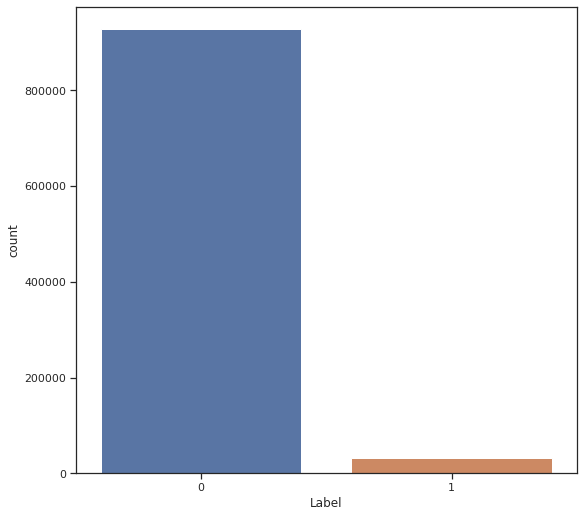

In [17]:
plt.figure(figsize=(8, 8))
sns.countplot('Label', data=feature_matrix)

In [18]:
feature_matrix.isna().sum().sort_values(ascending=False)

SKEW(Results.CUM_MEAN(LuckyNo))                7636
SKEW(Results.LuckyNo)                          7636
SKEW(Results.DrawNo)                           7636
TREND(Results.CUM_MEAN(LuckyNo), DrawDate)     7636
PERCENTILE(TREND(Results.DrawNo, DrawDate))    7636
                                               ... 
CUM_SUM(SUM(Results.LuckyNo))                     0
CUM_SUM(MIN(Results.TotalStrike))                 0
NUM_UNIQUE(Results.MONTH(DrawDate))               0
NUM_UNIQUE(Results.HOUR(DrawDate))                0
NumberId                                          0
Length: 213, dtype: int64

In [19]:
feature_matrix.isnull().sum().sort_values(ascending=False)

SKEW(Results.CUM_MEAN(LuckyNo))                7636
SKEW(Results.LuckyNo)                          7636
SKEW(Results.DrawNo)                           7636
TREND(Results.CUM_MEAN(LuckyNo), DrawDate)     7636
PERCENTILE(TREND(Results.DrawNo, DrawDate))    7636
                                               ... 
CUM_SUM(SUM(Results.LuckyNo))                     0
CUM_SUM(MIN(Results.TotalStrike))                 0
NUM_UNIQUE(Results.MONTH(DrawDate))               0
NUM_UNIQUE(Results.HOUR(DrawDate))                0
NumberId                                          0
Length: 213, dtype: int64

In [20]:
feature_matrix[feature_matrix.isnull().any(axis=1)].time.unique()

array(['2012-01-01T00:00:00.000000000', '2012-02-01T00:00:00.000000000',
       '2012-03-01T00:00:00.000000000', '2012-04-01T00:00:00.000000000',
       '2012-05-01T00:00:00.000000000', '2012-06-01T00:00:00.000000000',
       '2012-07-01T00:00:00.000000000', '2012-08-01T00:00:00.000000000',
       '2012-09-01T00:00:00.000000000', '2012-10-01T00:00:00.000000000',
       '2012-11-01T00:00:00.000000000', '2012-12-01T00:00:00.000000000',
       '2013-01-01T00:00:00.000000000', '2013-02-01T00:00:00.000000000',
       '2013-03-01T00:00:00.000000000', '2013-04-01T00:00:00.000000000',
       '2013-05-01T00:00:00.000000000', '2013-06-01T00:00:00.000000000',
       '2013-07-01T00:00:00.000000000', '2013-08-01T00:00:00.000000000',
       '2013-09-01T00:00:00.000000000', '2013-10-01T00:00:00.000000000',
       '2013-11-01T00:00:00.000000000', '2013-12-01T00:00:00.000000000',
       '2014-01-01T00:00:00.000000000', '2014-02-01T00:00:00.000000000',
       '2014-03-01T00:00:00.000000000', '2014-04-01

In [21]:
feature_matrix[feature_matrix.isnull().any(axis=1)].head()

,NumberId,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),...,CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year
116,3294,2012-01-01,NaN,NaN,NaN,3294,1,104596,3294,1,104596,3294,1,104596.0,NaN,NaN,NaN,3294,1,14682,104596,NaN,1,3294,1,104596,NaN,NaN,NaN,1,1,6,0,491788740.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,5001.828161,1.0,192504.336473,1,6,0,0.50005,NaN,0.053427,NaN,0.001001,0.001901,0.001901,0.329665,0.50005,0.773887,NaN,NaN,NaN,NaN,0.002201,NaN,0.329665,0.50005,NaN,0.329665,NaN,0.002201,NaN,0.50005,0.329665,0.50005,0.007804,1.0,1,1,1,1,2012
126,3455,2012-01-01,0.0,0.0,90302.485705,3455,1,327109,3455,1,199402,3455,1,263255.5,NaN,NaN,NaN,3455,1,65850,327109,240278400.0,2,6910,2,526511,NaN,NaN,NaN,1,28,4,0,305423940.0,45155.660222,1.699025e+08,0.279732,1.035840e+08,20767.726163,0.0,...,1.0,5003.717418,1.0,200090.691887,8,12,0,0.50005,0.50005,0.108754,NaN,0.037919,0.013057,0.013057,0.345773,0.50005,0.976538,0.50005,NaN,NaN,NaN,0.429465,NaN,0.345773,0.50005,0.457421,0.345773,0.987447,0.429465,NaN,0.50005,0.345773,0.50005,0.950675,1.0,1,1,1,1,2012
128,3479,2012-01-01,0.0,0.0,7990.306627,3479,1,362211,3479,1,350911,3479,1,356561.0,NaN,NaN,NaN,3479,1,73941,362211,20563200.0,2,6958,2,713122,NaN,NaN,NaN,1,10,4,0,22982340.0,4020.215271,1.454038e+07,0.024753,9.217371e+06,1849.084233,0.0,...,1.0,4997.881393,1.0,202004.621243,4,12,0,0.50005,0.50005,0.109555,NaN,0.087744,0.013057,0.013057,0.348174,0.50005,0.999650,0.50005,NaN,NaN,NaN,0.969335,NaN,0.348174,0.50005,0.001808,0.348174,0.002209,0.969335,NaN,0.50005,0.348174,0.50005,0.999900,1.0,1,1,1,1,2012
199,5870,2012-01-01,0.0,0.0,126014.206582,5870,1,239204,5870,1,60993,5870,1,150098.5,NaN,NaN,NaN,5870,1,45633,239204,350352000.0,2,11740,2,300197,NaN,NaN,NaN,1,19,8,0,579657540.0,62983.155445,2.477363e+08,0.390354,1.443588e+08,28975.114573,0.0,.

### Data Cleansing

In [0]:
## Fill all NaN with 0
feature_matrix = feature_matrix.fillna(0)

In [23]:
feature_matrix.isnull().sum().sort_values(ascending=False)

year                                             0
SKEW(Results.TIME_SINCE(DrawDate))               0
MEAN(Results.CUM_MEAN(LuckyNo))                  0
MEAN(Results.CUM_SUM(DrawNo))                    0
MEAN(Results.PERCENTILE(TotalStrike))            0
                                                ..
CUM_SUM(SKEW(Results.TotalStrike))               0
CUM_SUM(LAST(Results.DrawNo))                    0
CUM_SUM(SKEW(Results.DrawNo))                    0
CUM_SUM(TREND(Results.TotalStrike, DrawDate))    0
NumberId                                         0
Length: 213, dtype: int64

In [24]:
feature_matrix.isna().sum().sort_values(ascending=False)

year                                             0
SKEW(Results.TIME_SINCE(DrawDate))               0
MEAN(Results.CUM_MEAN(LuckyNo))                  0
MEAN(Results.CUM_SUM(DrawNo))                    0
MEAN(Results.PERCENTILE(TotalStrike))            0
                                                ..
CUM_SUM(SKEW(Results.TotalStrike))               0
CUM_SUM(LAST(Results.DrawNo))                    0
CUM_SUM(SKEW(Results.DrawNo))                    0
CUM_SUM(TREND(Results.TotalStrike, DrawDate))    0
NumberId                                         0
Length: 213, dtype: int64

In [25]:
feature_matrix[feature_matrix.isnull().any(axis=1)].head()

,NumberId,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),...,CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year


### Feature Correlation

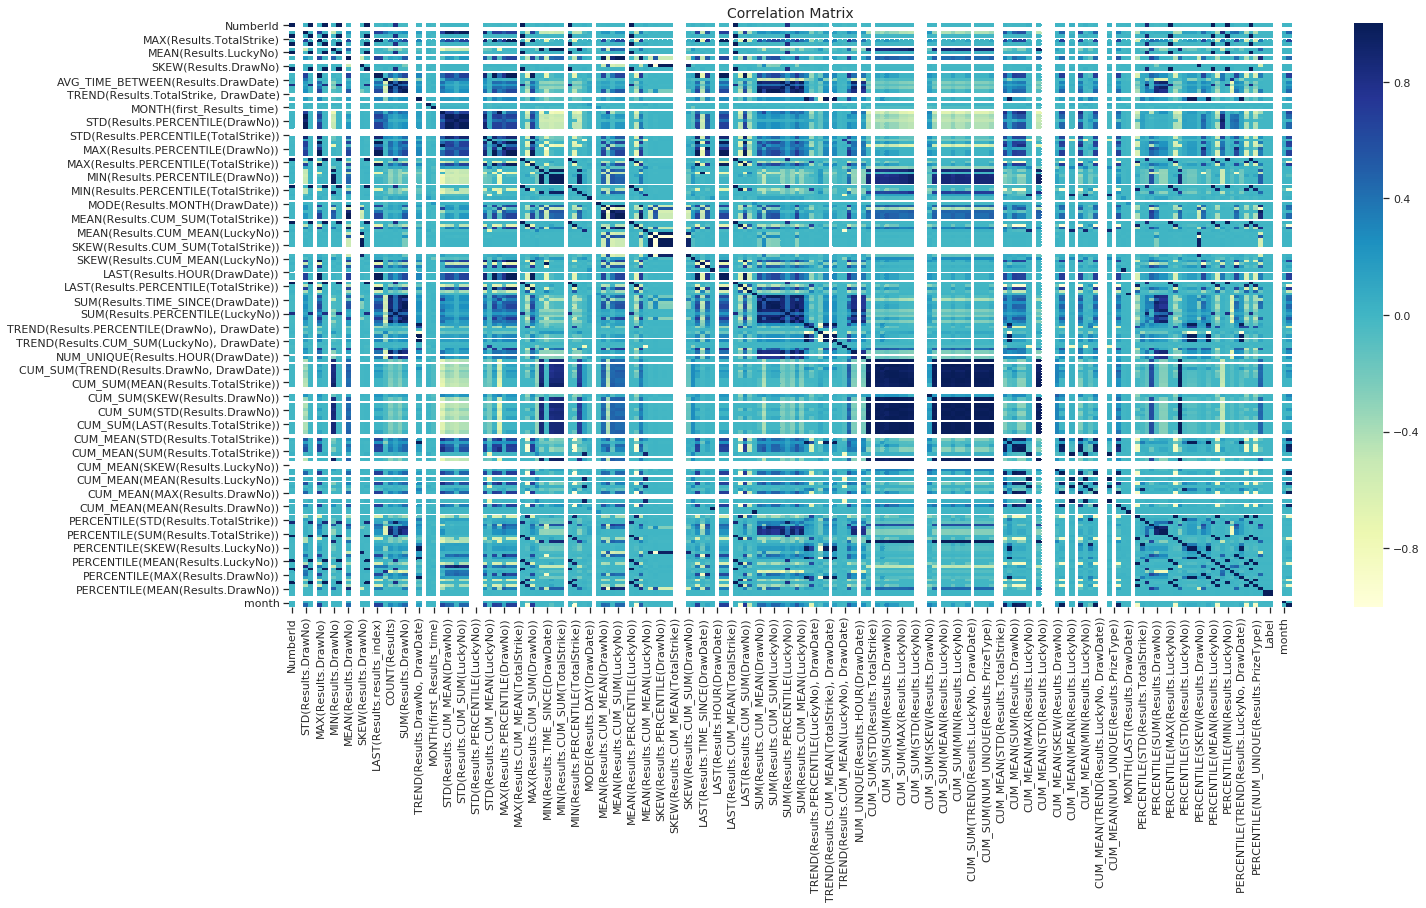

In [26]:
plot_correlation_matrix(feature_matrix)

### Visualization

In [42]:
X = feature_matrix.drop(columns = ['NumberId', 'time','date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
X.shape, X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959893 entries, 0 to 959892
Columns: 207 entries, STD(Results.LuckyNo) to LAST(Results.PrizeType)_Prize
dtypes: float64(145), int64(60), uint8(2)
memory usage: 1.5 GB


((959893, 207), None)

In [43]:
y = feature_matrix['Label']
y.shape, y

((959893,), 0         1
 1         1
 2         1
 3         1
 4         1
          ..
 959888    0
 959889    0
 959890    0
 959891    0
 959892    0
 Name: Label, Length: 959893, dtype: int64)

#### MinMaxScaler

<Figure size 576x576 with 0 Axes>

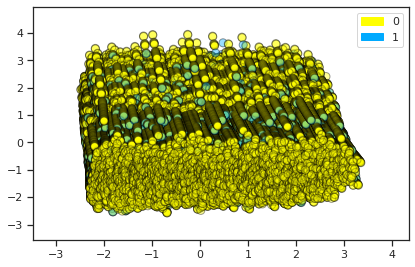

In [53]:
# Use PCA to find the 1st 2 principal components
X_normalized = MinMaxScaler().fit(X).transform(X)  
pca = PCA(n_components = 2).fit(X_normalized)
X_pca = pca.transform(X_normalized)

# Plot the PCA transformed version
plt.figure(figsize=(8, 8))
plot_labelled_scatter(X_pca, y, ['0', '1'])

# plt.xlabel('First principal component')
# plt.ylabel('Second principal component')
# plt.title('PCA (n_components = 2)');

#### StandardScaler

<Figure size 576x576 with 0 Axes>

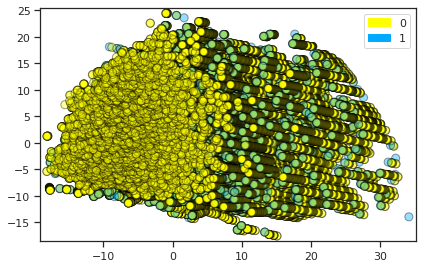

In [54]:
# Use PCA to find the 1st 2 principal components
X_normalized = StandardScaler().fit(X).transform(X)  
pca = PCA(n_components = 2).fit(X_normalized)
X_pca = pca.transform(X_normalized)
plt.figure(figsize=(8, 8))
plot_labelled_scatter(X_pca, y, ['0', '1'])

Use **StandardScaler** seems to be better!

## Balancing the data

In [0]:
X = feature_matrix.drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'month', 'year'])
y = feature_matrix['Label']

In [0]:
# Oversampling followed by under-sampling
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

# smt = SMOTETomek(ratio='auto')
smt = SMOTE()
X_smt, y_smt = smt.fit_sample(X, y)

In [0]:
# Use PCA to find the 1st 2 principal components
X_normalized = StandardScaler().fit(X).transform(X_smt)  
pca = PCA(n_components = 2).fit(X_normalized)
X_pca = pca.transform(X_normalized)
plt.figure(figsize=(8, 8))
plot_labelled_scatter(X_pca, y_smt, ['0', '1'])

<Figure size 576x576 with 0 Axes>